# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run shared detector on bash
```bash
python3 /home/kiro-ros/Projects/rnb-planning/src/scripts/demo_202107/demo_utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_CAM = False
ENABLE_DETECT = True
ENABLE_O3D = True

CONNECT_INDY = False
CONNECT_MOBILE = False

CONNECT_TASK_PLANNER = False
VISUALIZE = False
VERBOSE = False
PLANNING_MULTIPROC = True
N_AGENTS = 10
NODE_TRIAL_MAX = N_AGENTS * 2
MAX_SOL_NUM = 5
BASE_COST_CUT = 110

TIMEOUT_MOTION = 0.5
TIMEOUT_FULL = 5

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.15, 0.32]
TOOL_THICKNESS = 0.05
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

COL_COLOR = (1,1,1,0.2)

IP_CUR = "192.168.0.10"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.10
Mobile ROB IP: 192.168.0.102


In [2]:
if CONNECT_TASK_PLANNER:
    from demo_proto.TaskExecuteServer import serve_on_thread
    servicer = serve_on_thread()

In [3]:
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.detector.multiICP.multiICP import *
from pkg.detector.camera.realsense import RealSense
from pkg.detector.detector_interface import DetectionLevel
from pkg.detector.multiICP.config import *

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections
from demo_utils.demo_config import *
from demo_utils.detection_util import *

from pkg.utils.shared_function import *
clear_channels_on("kiromobilemap")

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7kiro, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 12, -7, 5, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
CAM_LINK = TIP_LINK.replace("tcp", "link6")
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=CAM_LINK, center=(-0.0785, 0, 0.073))

add_brush(gscene, face_name=TOOL_NAME, tool_link=TIP_LINK,
          thickness=TOOL_THICKNESS, tool_dim=TOOL_DIM,
          col_color=COL_COLOR)

HOME_POSE = crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=0.5, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(ROBOT_TYPE, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(DATASET_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene, node_trial_max=NODE_TRIAL_MAX)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']

if CONNECT_MOBILE:
    assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"
    
if CONNECT_CAM:
    camgen = CameraGenerator()
    realsense = RealSense()

connection command:
kmb0: True
indy1: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
File not exist: indy7kiro-frontX-PRQ.pkl
File not exist: indy7kiro-upZ-PRQ.pkl
File not exist: indy7kiro-downZ-PRQ.pkl


#### 0.1.2 Load environment map

In [4]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR, CONNECT_MOBILE)
            
VALID_BOX_SCALE = 0.8
VALID_SCORE_CUT = 50
kmb.coster = (lambda Q: 
                  np.max(
                      kmm.get_box_costs(mobile_box, Q, kmm.T_bi, kmm.cost_im, kmm.resolution, 
                                        scale=VALID_BOX_SCALE)))
kmb.cost_cut = VALID_SCORE_CUT
kmb.gscene = gscene

kmm.init_node(timeout=10)

In [5]:
pole_pt_list, pole_res = kmm.update_map(gscene, crob, MOBILE_BASE, timeout=100)

IndexError: list index out of range

## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

In [4]:
if CONNECT_CAM:
    micp = MultiICP(realsense)
    micp.initialize()
else:
    micp = MultiICP(None)
    cameraMatrix = np.array([[909.957763671875, 0., 638.3824462890625],
                             [0., 909.90283203125, 380.0085144042969],
                             [0., 0., 1]])
    distCoeffs = np.array([0.]*5)
    depth_scale=1 / 3999.999810010204
    config_list = [cameraMatrix, distCoeffs, depth_scale]
    img_dim = (720, 1280)
    micp.initialize(config_list, img_dim)

Camera is not set - skip initialization, use manually given camera configs


In [5]:
from pkg.detector.multiICP.shared_detector import SharedDetectorGen
sd = SharedDetectorGen(tuple(reversed(micp.dsize))+(3,))()
if ENABLE_DETECT:
    sd.init()

In [6]:
if CONNECT_TASK_PLANNER:
    while servicer.object_info_running.object_id < 0:
        time.sleep(1)

#### 1.1.1 Move to bed-seek pose 

In [7]:
Q_CUR = kmb.get_qcur()

VIEW_POSE = crob.home_pose[6:]
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

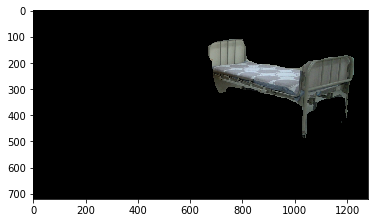

In [8]:
turn_dir = 1
Q0 = np.rad2deg(VIEW_POSE_EXT[6:])
dQ = np.zeros(6)
while True:
    # Take a picture again after rotate
    if CONNECT_CAM:
#         rdict = camgen.stream_capture_image(obj_type="bed", crob=crob)
        color_img, depth_img, Q = micp.get_image()
        cam_mtx, discoeffs, d_scale = micp.get_camera_config()
        intrins = [micp.img_dim[1], micp.img_dim[0],
                   cam_mtx[0, 0], cam_mtx[1, 1],cam_mtx[0, 2], cam_mtx[1, 2]]
        rdict = {'color': color_img,
                 'depth': depth_img,
                 'intrins': intrins, 'depth_scale': d_scale}
    else:
        rdict, VIEW_POSE_EXT = load_rdict("bed")
        

    cdp = rdict2cdp(rdict)
        
    
    if ENABLE_DETECT:
        # Output of inference(mask for detected bed)
        mask_out_list = sd.inference(color_img=rdict['color'])
        mask_out = mask_out_list[class_dict["bed"]]
        cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed.png"), mask_out)
    else:
        mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed.png"))[:,:,0]
        
    if np.any(mask_out):
        cdp_masked = apply_mask(cdp, mask_out)
        plt.imshow(cdp_masked.color[:,:,[2,1,0]])
        break
    if CONNECT_INDY:
        with indy:
            turn_dir *= -1
            dQ = np.add(dQ, [5,0,0,0,0,0])
            Qto = Q0+turn_dir*dQ
            Qto[0] = (Qto[0]+180/2)%180-180/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
            VIEW_POSE_EXT[6:] = np.deg2rad(indy.get_joint_pos())

#### 1.1.2  detect bed and add to the scene

In [9]:
from pkg.utils.utils import *
gtimer = GlobalTimer.instance()

In [10]:
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_bc_bed_view = np.copy(T_bc)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)

In [11]:
obj_info_dict = get_obj_info()
micp_bed = MultiICP_Obj(obj_info_dict["bed"], None,
                        OffsetOnModelCoord("bed", R=np.matmul(T_cb[:3, :3], Rot_axis(3, np.pi)),
                                          offset=np.matmul(T_cb[:3, :3], (1.1 * 0.5, 0, -0.5))))

mrule_closet = MaskBoxRule("closet", "bed", merge_rule=np.all)
mrule_closet.update_rule = ClosetRuleFun(mrule_closet)
micp_closet = MultiICP_Obj(obj_info_dict["closet"], 
                           mrule_closet,
                           OffsetOnModelCoord("closet", 
                                             offset=(0, 1, 0.3),
                                             use_median=True
                                     ))
micp_dict = {"bed": micp_bed, "closet": micp_closet}
micp.set_config(micp_dict, sd, crob, viewpoint)

In [12]:
VISUALIZE = False
if ENABLE_O3D:
    if np.any(mask_out):
        if not CONNECT_CAM:
            micp.cache_sensor(cdp.color, cdp.depth, VIEW_POSE_EXT)
        pose_dict = micp.detect(name_mask = "bed", visualize=VISUALIZE)
        T_bo_bed = pose_dict["bed"]
    
    bed_center = T_bo_bed[:3,3]
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    Tbm = gscene.get_tf(MOBILE_BASE, VIEW_POSE_EXT)
    Tmo = np.matmul(SE3_inv(Tbm), T_bo_new)
    if Tmo[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))
    
else:
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))

bed_vis = gscene.NAME_DICT["bed_vis"]

name_mask is bed
===== Detected : bed, 1 object(s) =====

'bed' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.768721e-01, inlier_rmse=7.140152e-02, and correspondence_set size of 5562
Access transformation to get result.
Transformation is:
[[ 0.86549497 -0.06963886  0.49605332  0.11550792]
 [-0.24120712 -0.92585788  0.29087168 -0.19204667]
 [ 0.43901891 -0.37139955 -0.81812272  4.56528575]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=8.636201e-01, inlier_rmse=4.551750e-02, and correspondence_set size of 2419
Access transformation to get result.
Transformation is:
[[ 0.86833787 -0.04812134  0.49363316  0.13652268]
 [-0.20524774 -0.94092483  0.26932109 -0.13914305]
 [ 0.45151161 -0.33517878 -0.82691745  4.58743183]
 [ 0.          0.          0.          1.        ]]
Found 6DoF pose of bed


### 1.2 Detect Closet

#### 1.2.1  move to full view position

##### calc fule view pose

In [13]:
VIEW_MOVED = np.deg2rad([  0., 60.,  -60.,  -0.,  -100., 0, 0])
VIEW_POSE_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if ENABLE_O3D:
    h_fov_hf = np.arctan2(cdp.intrins[0], 2*cdp.intrins[2])
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(
        cdp2pcd(cdp), cdp2pcd(cdp_masked), T_bc, T_bo, 
        bed_dims=bed_mat.dims, visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    h_fov_hf = np.pi/4
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_refs = [150]
elif CLOSET_LOCATION == "RIGHT":       
    angle_refs = [-150]
    
bed_dim = np.linalg.norm(bed_mat.dims)
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3
for angle_ref in angle_refs:
    for _ in range(100):
        angle_view = angle_ref + np.random.uniform(-10, 10)
        dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/4
        Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
        Tbs = np.matmul(Tbs, 
                        SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
        Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                        SE3(np.identity(3), (-dist_view, 0,0)))
        Tbc = np.matmul(Tbs, Tsc)
        Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
        Tmc[:3,:3] = np.identity(3)
        Tbm = np.matmul(Tbc, SE3_inv(Tmc))
        full_view_ext = np.copy(VIEW_POSE_EXT)
        full_view_ext[:2] = Tbm[:2,3]
        full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
        gscene.show_pose(full_view_ext)
        res = kmb.check_valid(full_view_ext[:6])
        if res:
            VIEW_MOVED_EXT = full_view_ext
            print("Full view loc: {}".format(np.round(VIEW_MOVED_EXT[:3], 2)))
            break
    if res:
        break

CLOSET on LEFT
Full view loc: [ 2.5   2.89 -0.65]


##### move to full view pose

In [14]:
if CONNECT_INDY and CONNECT_MOBILE:
    gscene.show_pose(crob.get_real_robot_pose())
    print("real_robot_pose: {}".format(
        np.round(crob.get_real_robot_pose(), 2)))

In [15]:
# VIEW_MOVED = VIEW_POSE
# VIEW_MOVED_EXT = VIEW_POSE_EXT
# CLOSET_LOCATION = "LEFT"

In [16]:
gscene.show_pose(VIEW_MOVED_EXT)

In [17]:
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    kmb.joint_move_make_sure(VIEW_MOVED_EXT[:6])
    VIEW_MOVED_EXT = crob.get_real_robot_pose()
if not CONNECT_INDY:
    VIEW_MOVED_EXT[6:] = VIEW_MOVED.copy()
gscene.show_pose(VIEW_MOVED_EXT)
print("VIEW_MOVED_EXT: {}".format(
    np.round(VIEW_MOVED_EXT, 2)))

VIEW_MOVED_EXT: [ 2.5   2.89 -0.65  0.    0.    0.    0.    1.05 -1.05 -0.   -1.75  0.
  0.  ]


#### 1.2.2 detect bed and closet together

In [18]:
T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
T_cb = SE3_inv(T_bc)

In [19]:
micp_bed = MultiICP_Obj(obj_info_dict["bed"], None,
                        OffsetOnModelCoord("bed", R=np.matmul(T_cb[:3, :3], Rot_axis(3, np.pi)),
                                          offset=np.matmul(T_cb[:3, :3], (1.1 * 0.5, 0, -0.5))))

mrule_closet = MaskBoxRule("closet", "bed", merge_rule=np.all)
mrule_closet.update_rule = ClosetRuleFun(mrule_closet)
micp_closet = MultiICP_Obj(obj_info_dict["closet"], 
                           mrule_closet,
                           OffsetOnModelCoord("closet", 
                                             offset=(0, 1, 0.3),
                                             use_median=True
                                     ))
micp_dict = {"bed": micp_bed, "closet": micp_closet}
micp.set_config(micp_dict, sd, crob, viewpoint)

In [20]:
VISUALIZE = False
# capture image of full view
if CONNECT_CAM:
#     rdict = camgen.stream_capture_image(obj_type="full_view", crob=crob)
    color_img, depth_img, Q = micp.get_image()
    cam_mtx, discoeffs, d_scale = micp.get_camera_config()
    intrins = [micp.img_dim[1], micp.img_dim[0],
               cam_mtx[0, 0], cam_mtx[1, 1],
               cam_mtx[0, 2], cam_mtx[1, 2]]
    rdict = {'color': color_img,
             'depth': depth_img,
             'intrins': intrins, 'depth_scale': d_scale}
else:
    rdict, VIEW_MOVED_EXT = load_rdict("full_view")
    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    gscene.show_pose(VIEW_MOVED_EXT)
    
cdp = rdict2cdp(rdict)

if ENABLE_DETECT:
    # Output of inference(mask for detected bed)
    mask_out_list = sd.inference(color_img=cdp.color)
    mask_out = mask_out_list[class_dict["bed"]]
    cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed_re.png"), mask_out)
else:
    mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed_re.png"))[:,:,0]
    
if np.any(mask_out):
    if not CONNECT_CAM:
        micp.cache_sensor(cdp.color, cdp.depth, VIEW_POSE_EXT)

    micp_bed.clear()
    pose_dict = micp.detect(visualize=VISUALIZE)
    T_bo_bed = pose_dict["bed"]
    T_bo = pose_dict["closet"]
    
    # adjust bed
    T_bo_bed[2]=0
    T_bo_bed[:3, :3]=Rot_axis(3, Rot2axis(T_bo_bed[:3, :3], 3))
    move_bed(gscene, T_bo_bed[:3,3], Rot2rpy(T_bo_bed[:3,:3]))
     
    # adjust closet
    T_bo[2]=0
    T_bo[:3, :3]=Rot_axis(3, Rot2axis(T_bo[:3, :3], 3))

    if not ENABLE_O3D:
        T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                         bed_rpy))
    
    closet_leftup, closet_rightup, closet_down = add_closet(
        gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
        COLOR_CLOSET_COL=(0,1,0,0.3))

    add_backwall(gscene)

else:
    raise(RuntimeError("bed not detected"))

name_mask is None
===== Detected : handbag, 1 object(s) =====
===== Detected : suitcase, 1 object(s) =====
===== Detected : bowl, 3 object(s) =====
===== Detected : bed, 1 object(s) =====
===== Detected : clock, 1 object(s) =====

'bed' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.356096e-01, inlier_rmse=6.947419e-02, and correspondence_set size of 5017
Access transformation to get result.
Transformation is:
[[ 0.82106408 -0.09176436  0.56341204 -0.60049456]
 [-0.21152159 -0.96564231  0.15097518  0.6567967 ]
 [ 0.53020031 -0.24313411 -0.81226432  4.61422338]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=8.388365e-01, inlier_rmse=4.116285e-02, and correspondence_set size of 2134
Access transformation to get result.
Transformation is:
[[ 0.82675477 -0.05717426  0.55964962 -0.57458603]
 [-0.1478396  -0.98193666  0.11808386  0.718456

In [21]:
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["bed_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["closet_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["room_box"], 
                    pole_pt_list, VIEW_POSE_EXT, inside=False)
pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res)
gcheck.ignore_always = pole_list

gscene.update_markers_all() 

NameError: name 'kmm' is not defined

In [ ]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()


## 2. Prepare cleaning

In [ ]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [ ]:
# mplan.reset_log(flag_log=True)
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, 
                           gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

In [ ]:
adjust_count_list = []
THRESH = 0.05
def look_closet_get_offset(gxter, crob, mplan, robot_name, Qref):
    Qref_in = np.copy(Qref)
    Qref = np.copy(Qref)
    for _ in range(5):
        traj, succ = get_look_motion(mplan, robot_name, Qref, 
                                     target_point=gscene.NAME_DICT["closet_leftup"],
                                     com_link=CAM_LINK,
                                     cam_link=CAM_LINK,
                                     view_dir=[0,0,1],timeout=1)
        traj_rev = np.array(list(reversed(traj)))

    if not succ:
        look_closet_get_offset.Qref_fail = Qref
        raise(RuntimeError("Get Look Motion Fail"))

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        with indy: # move to look
            crob.move_joint_traj(traj, one_by_one=True)

    time.sleep(1)

#     icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
#                        Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))

    adjust_count_list.append(1)
    if CONNECT_CAM:
#         rdict = camgen.stream_capture_image( 
#                                      obj_type="closet_{}".format(len(adjust_count_list)), 
#                                      crob=crob)
        color_img, depth_img, Q = micp.get_image()
        cam_mtx, discoeffs, d_scale = micp.get_camera_config()
        intrins = [micp.img_dim[1], micp.img_dim[0],
                   cam_mtx[0, 0], cam_mtx[1, 1],
                   cam_mtx[0, 2], cam_mtx[1, 2]]
        rdict = {'color': color_img,
                 'depth': depth_img,
                 'intrins': intrins, 'depth_scale': d_scale}
    else:
        try:
            rdict, Qref = load_rdict("closet_{}".format(len(adjust_count_list)))
            gscene.show_pose(Qref)
        except Exception as e:
            TextColors.YELLOW.println("[WARN] out of saved look refine data")
            print(e)
            Qcur = np.copy(Qref_in)
            Qcur[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                         [0.05, 0.05, 0.05, 0, 0, 0])

            Qtar = np.copy(Qref_in)
            Qtar[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                         [0.05, 0.05, 0.05, 0, 0, 0])
            return Qcur, Qtar

    T_bc, T_bs_closet = viewpoint.get_tf(Qref), gscene.NAME_DICT["closet_vis"].get_tf(Qref)

    micp_closet.clear()
    pose_dict = micp.detect(name_mask="closet", visualize=VISUALIZE)
    T_bo_close = pose_dict["closet"]
    pcd_masked = micp_closet.pcd
    
#     cdp = rdict2cdp(rdict)
#     pcd_closet = cdp2pcd(cdp, T_bc)

#     with gtimer.block("masking"):
#         pcd_masked = mask_boxes(pcd_closet, 
#                             boxes=[gscene.NAME_DICT["closet_box"]], 
#                             Q=Qref, inside=True, 
#                             merge_rule=np.all, link_ref="base_link")
#         pcd_masked = mask_boxes(pcd_masked, 
#                             boxes=[gscene.NAME_DICT["bed_box"], 
#                                    gscene.NAME_DICT["bed_wall"], 
#                                    gscene.NAME_DICT["floor_box"],
#                                    gscene.NAME_DICT["back_wall"]], 
#                             Q=Qref, inside=False, 
#                             merge_rule=np.all, link_ref="base_link")

#     with gtimer.block("adding"):
#         icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.2)

#     initial_guess = gscene.NAME_DICT["closet_vis"].get_tf(Qref)
#     with gtimer.block("compute_front_ICP"):
#         # front_ICP
#         T_bo_close1, fitness1 = icp_closet.compute_front_ICP(
#             T_bc, initial_guess, thres=THRESH, visualize=VISUALIZE)
#         T_bo_close = T_bo_close1
# #         T_bo_close2, fitness2 = icp_closet.compute_front_ICP(
# #             T_bc, initial_guess, thres=THRESH*2, visualize=VISUALIZE)
# #         T_bo_close = T_bo_close1 if fitness1 > fitness2 else T_bo_close2

    # calculate transform based on obtained points
    pcd_center_prev = pcd_masked.get_center()

    T_bo_p = SE3(T_bo_close[:3,:3], pcd_center_prev)
    T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
    T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
    T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
    T_bo_c_fix[2,3] = 0

    # get Twoff from redetection
    Tbo0, Tbo1 = T_bs_closet, T_bo_c_fix
    Tbw0 = gscene.get_tf(gxter.mobile_link, Qref)
    Tow1 = np.matmul(SE3_inv(Tbo1), Tbw0)
    Tbw1 = np.matmul(Tbo0, Tow1)

    if CONNECT_CAM and CONNECT_MOBILE:
        Qcur = np.copy(Qref)
        Qcur[:2] = Tbw1[:2,3]
        Qcur[2] = Rot2axis(Tbw1[:3,:3], 3)

        Tow0 = np.matmul(SE3_inv(Tbo0), Tbw0)
        Tbw1tar = np.matmul(Tbo1, Tow0)
        Qtar = np.copy(Qref)
        Qtar[:2] = Tbw1tar[:2,3]
        Qtar[2] = Rot2axis(Tbw1tar[:3,:3], 3)
    else:
        Qcur = np.copy(Qref_in)
        Qcur[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
        
        Qtar = np.copy(Qref_in)
        Qtar[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
    return Qcur, Qtar

In [ ]:
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)
        
    indy.collision_policy = POLICY_NO_COLLISION_DETECTION
swp_fin_list = []

Qcur = VIEW_MOVED_EXT
mode_switcher=ModeSwitcherKMB(pscene, push_dist=0.0)

## 3. Bed cleaning

In [ ]:
VISUALIZE=False

In [ ]:
T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.02, margin=0.05)
gscene.add_virtual_guardrail(closet_rightup, HEIGHT=0.02, margin=0.05)
gscene.add_virtual_guardrail(closet_down, HEIGHT=0.02, margin=0.05, axis="xy")

In [ ]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
tplan.node_trial_max = NODE_TRIAL_MAX

gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

covereds_all = []
for _ in range(1):
    gxter.get_division_dict(bed_mat, "front", "X", EE_HEIGHT, xout_cut=True)
    gxter.init_base_divs(Qcur)
    # gxter.mark_tested(None, None, covereds_all, [])
    snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(
        Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, covereds=covereds_all)
    covereds_all = sorted(set(covereds_all+covereds))
    gxter.test_clear()
    len_covered, len_all = len(covereds_all), len(gxter.surface_div_centers)
    print("########################### TRIAL ONCE DONE ( {} / {} )########################".format(len_covered, len_all))
    if len_covered >= len_all:
        break
    print(gtimer)
gscene.clear_virtuals()

## 4. Closet cleaning

In [ ]:
VISUALIZE = False

In [ ]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_rightup, HEIGHT=0.2, margin=0.15)
tplan.node_trial_max = NODE_TRIAL_MAX * 2

gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION*1.5, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_rightup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_ru, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, adjust_once=False)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

In [ ]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.1, margin=0.1)
tplan.node_trial_max = NODE_TRIAL_MAX

gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_leftup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_lu, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

In [ ]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(
    closet_down, HEIGHT=0.05, margin=0.1, axis="xy")
tplan.node_trial_max = NODE_TRIAL_MAX * 2

gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION*2, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_down, "down", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(
    Qcur, -1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, 
    adjust_once=False)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

### Finish

In [ ]:
if CONNECT_TASK_PLANNER:
    servicer.mark_task_finished()

* MAX_SOL_NUM 적용 v
* 위 오른쪽 안닦이는 문제 파악 - guardrail 마진 - v
* 아래 닦을 때 위쪽 가운데 바운더리 추가 - v
* 침대 닦을 때 옷장 바운더리 마진 추가 - v
* 위치 보정, 드리프트 코드 검토 - ok - v
* 인디 툴 무게 v
* 툴 조인트 플래닝에 추가?

* Adjust에서 Qref와 Qcur 분리